# Tool Architecture

Contextualizing the problem in ML
To contextualize the problem, this has been divided into goals, each goal contextualized in a different area of requirements engineering.
- Goal 1.	Support Change-Impact Analysis.
- Goal 2.	Domain mapping and ontology creation.
    - a.	Requirement analysis.
- Goal 3.	Trace or elicit safety-related aspects from existing norms and standards.
    - a.	Requirement elicitation.
- Goal 4.	Facilitating effective tracing, reuse, and analysis of system requirements to prevent safety violations.
    - a.	Classify safety violations.


## Import Data

The dataset originates from PURE, a requirements collection formatted in XML. All XML files share a standard namespace called 'req_document.xsd,' simplifying the development of a function to parse the XML files into a dataframe. This dataframe includes columns for the relevant XML tags, indicating whether the text corresponds to a requirement or information, the XML tree of the entry (or path), and the associated ID, that stands for the requirement number.

TODO: 
- Missing test of quality with other sources
- Import all in folder into instances of classes


In [1]:
import xml.etree.ElementTree as ET
import pandas as pd
import sys
import string
import re
import nltk
import pprint
from Utils import parse_xml

print(sys.version)
print(sys.executable)

# Specify the path to your XML filec
xml_file_path = r'C:\dev\NLP2RE_Sandbox\data\work_data\2007-ertms.xml'

# Define the namespace
namespace = {'ns': 'req_document.xsd'}

# import utils.ParseXML as ParseXML
df = parse_xml.process_xml_with_namespace(xml_file_path, namespace)
df.head(30)

3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]
c:\ProgramData\anaconda3\python.exe


KeyError: '[8] not found in axis'

## Clean Data
Having retrieved the text in the XML file to a workable format (dataframes), it is necessary to cleanup and tokenize the text.
This is not as straightforward as it might seem since care is needed to preserve special words such as those separated by hyphens (e-governance, non-functional, …). 


First, let’s tokenize the documents, remove common words as well as words that only appear once in the corpus:

### Remove punctiation, Tokenization and remove stopwords


In [41]:
from Utils import clean_data

clean_data_case = "lsa_preprocess"

if clean_data_case == "lsa_preprocess":
    df['text_clean'] = df['text'].apply(lambda x: clean_data.preprocess_data_str(x))
else:
    df['text_clean'] = df['text'].apply(lambda x: clean_data.clean_text(x.lower(),False,False))

# Display the sub-dataframe
df.head()

,tag,text,id,path,text_clean
0,title,E-GOVERNANCE MISSION MODE PROJECT (MMP),,req_document/title/title,"[e, govern, mission, mode, project, mmp]"
1,title,CRIME & CRIMINAL TRACKING NETWORK AND SYSTEMS ...,,req_document/title/title,"[crime, crimin, track, network, system, cctn]"
2,title,FUNCTIONAL REQUIREMENTS SPECIFICATION V1.0 (DR...,,req_document/title/title,"[function, requir, specif, v1, 0, draft]"
3,title,MINISTRY OF HOME AFFAIRS GOVERNMENT OF INDIA,,req_document/title/title,"[ministri, home, affair, govern, india]"
4,version,1.0,,req_document/version,"[1, 0]"


## Create Corpus 


In [42]:
def df_tokenized_2_corpus(df_column, min_word_freq=1):
    #FIXME: this does not return a corpus. A corpus is processed after the Dictionary. 
    """
    Process a DataFrame attribute containing a list of tokenized data.

    Parameters:
    - df_column (pandas.Series): DataFrame column containing a list of tokenized data.
    - min_word_freq (int): minimum word frequency

    Returns:
    - processed_corpus (list of lists): Processed corpus after filtering based on word frequencies.
    """
    # Count word frequencies
    from collections import defaultdict
    frequency = defaultdict(int)
    
    # Count word frequencies
    for text_list in df_column:
        for token in text_list:
            frequency[token] += 1

    # Only keep words that appear more than once
    processed_corpus = [[token for token in text_list if frequency[token] > min_word_freq] for text_list in df_column]
    
    return processed_corpus


# Example usage:
clean_text = df_tokenized_2_corpus(df['text_clean'], 2)
pprint.pprint(clean_text)

[['e', 'mode'],
 ['crime', 'crimin', 'track', 'network', 'system', 'cctn'],
 ['function', 'requir', 'specif', 'v1', '0'],
 ['home'],
 ['1', '0'],
 [],
 ['function',
  'requir',
  'specif',
  'report',
  'provid',
  'detail',
  'descript',
  'function',
  'requir',
  'version',
  'cctn',
  'key',
  'guid',
  'principl',
  'function',
  'design',
  'cctn',
  'v1',
  '0',
  'critic',
  'function',
  'provid',
  'valu',
  'polic',
  'personnel',
  'cut',
  'turn',
  'improv',
  'area',
  'investig',
  'crime',
  'crimin'],
 ['function', 'overview'],
 ['cctn',
  'v1',
  '0',
  'function',
  'design',
  'valu',
  'record',
  'citizen',
  'within',
  'crime',
  'investig',
  'area',
  'base',
  'guid',
  'principl',
  'state',
  'differ',
  'function',
  'block',
  'identifi',
  'detail',
  'function',
  'block'],
 ['descript', 'modul', 'function', 'requir'],
 ['function',
  'cctn',
  'applic',
  'provid',
  'valu',
  'polic',
  'personnel',
  'oper',
  'cut',
  'eas',
  'day',
  'day',
  'op

## Dictionary

In [43]:
from gensim import corpora

def corpus_2_dictionary(corpus):
    """
    Associate each word in the corpus with a unique integer ID
    This dictionary defines the vocabulary of all words that our processing knows about.

    Parameters:
    - corpus (str): A list of input text to be indexed.


    Returns:
    - A dictionary of unique tokes with an associated ID
    """
    return corpora.Dictionary(corpus)

doc_dictionary = corpus_2_dictionary(clean_text)
pprint.pprint(doc_dictionary.token2id)



{'0': 8,
 '1': 14,
 '2': 269,
 '20': 193,
 '3': 246,
 '9241': 190,
 'abil': 69,
 'abl': 147,
 'accept': 109,
 'access': 126,
 'account': 210,
 'achiev': 143,
 'act': 48,
 'action': 114,
 'activ': 140,
 'adapt': 249,
 'addit': 100,
 'administr': 129,
 'advanc': 70,
 'alert': 95,
 'allow': 152,
 'also': 71,
 'altern': 197,
 'applic': 43,
 'appropri': 151,
 'architectur': 270,
 'area': 15,
 'attempt': 148,
 'attribut': 110,
 'audit': 128,
 'avail': 144,
 'avoid': 213,
 'base': 34,
 'behaviour': 250,
 'block': 35,
 'browser': 127,
 'cach': 283,
 'capabl': 130,
 'capac': 263,
 'care': 241,
 'case': 64,
 'categori': 124,
 'cctn': 2,
 'certain': 211,
 'chang': 157,
 'citizen': 36,
 'clear': 203,
 'clearli': 225,
 'click': 183,
 'color': 238,
 'colour': 185,
 'common': 174,
 'commun': 237,
 'complaint': 49,
 'compon': 248,
 'configur': 99,
 'connect': 276,
 'consist': 244,
 'contain': 222,
 'content': 186,
 'context': 115,
 'control': 149,
 'core': 271,
 'court': 65,
 'creat': 101,
 'crime': 3

## BOW

Word ID and freq

In [44]:
bow = [doc_dictionary.doc2bow(text) for text in clean_text]
pprint.pprint(bow)

[[(0, 1), (1, 1)],
 [(2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)],
 [(8, 1), (9, 1), (10, 1), (11, 1), (12, 1)],
 [(13, 1)],
 [(8, 1), (14, 1)],
 [],
 [(2, 2),
  (3, 1),
  (4, 1),
  (8, 1),
  (9, 4),
  (10, 2),
  (11, 1),
  (12, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 2),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 1)],
 [(9, 1), (33, 1)],
 [(2, 1),
  (3, 1),
  (8, 1),
  (9, 3),
  (12, 1),
  (15, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (23, 1),
  (27, 1),
  (31, 1),
  (34, 1),
  (35, 2),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 1)],
 [(9, 1), (10, 1), (18, 1), (42, 1)],
 [(2, 1),
  (9, 2),
  (17, 1),
  (25, 1),
  (26, 2),
  (28, 1),
  (31, 1),
  (43, 1),
  (44, 2),
  (45, 1),
  (46, 2)],
 [(47, 1)],
 [(23, 1),
  (26, 4),
  (34, 1),
  (36, 2),
  (42, 1),
  (45, 1),
  (47, 1),
  (48, 1),
  (49, 2),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (5

# Topic Modelling

## Sample
https://radimrehurek.com/gensim/models/ldamodel.html

In [57]:
import gensim
from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

# Create a corpus from a list of texts
common_dictionary = Dictionary(common_texts)
common_corpus = [common_dictionary.doc2bow(text) for text in common_texts]

# Train the model on the corpus.
lda = gensim.models.ldamodel.LdaModel(common_corpus, num_topics=10, id2word=common_dictionary)
topics = lda.print_topics()

# Print topics with words instead of IDs
for topic in topics:
    print(topic)


(0, '0.212*"user" + 0.212*"interface" + 0.212*"system" + 0.212*"eps" + 0.019*"trees" + 0.019*"graph" + 0.019*"human" + 0.019*"minors" + 0.019*"survey" + 0.019*"response"')
(1, '0.212*"graph" + 0.212*"survey" + 0.212*"minors" + 0.211*"trees" + 0.019*"user" + 0.019*"human" + 0.019*"system" + 0.019*"interface" + 0.019*"time" + 0.019*"computer"')
(2, '0.344*"trees" + 0.344*"graph" + 0.031*"human" + 0.031*"user" + 0.031*"minors" + 0.031*"system" + 0.031*"response" + 0.031*"interface" + 0.031*"eps" + 0.031*"survey"')
(3, '0.206*"computer" + 0.108*"user" + 0.108*"time" + 0.108*"survey" + 0.108*"system" + 0.108*"response" + 0.108*"interface" + 0.108*"human" + 0.010*"trees" + 0.010*"graph"')
(4, '0.083*"trees" + 0.083*"graph" + 0.083*"minors" + 0.083*"system" + 0.083*"user" + 0.083*"interface" + 0.083*"human" + 0.083*"time" + 0.083*"response" + 0.083*"computer"')
(5, '0.083*"trees" + 0.083*"graph" + 0.083*"system" + 0.083*"human" + 0.083*"user" + 0.083*"time" + 0.083*"minors" + 0.083*"survey" +

In [58]:
# Create a new corpus, made of previously unseen documents.
other_texts = [
    ['computer', 'time', 'graph'],
    ['survey', 'response', 'eps'],
    ['human', 'system', 'computer']
]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[0]
vector = lda[unseen_doc]  # get topic probability distribution for a document

pprint.pprint(vector)

[(0, 0.025000049),
 (1, 0.025006613),
 (2, 0.27500442),
 (3, 0.52496946),
 (4, 0.025000054),
 (5, 0.025000054),
 (6, 0.025000054),
 (7, 0.025004055),
 (8, 0.025015133),
 (9, 0.025000054)]


## Practice 

In [87]:
import gensim

lda_model = gensim.models.ldamodel.LdaModel(bow, num_topics=7, id2word= doc_dictionary)
#lda = gensim.models.ldamodel.LdaModel(common_corpus, num_topics=10, id2word=common_dictionary)

pprint.pprint(lda_model.print_topics())

[(0,
  '0.032*"use" + 0.027*"user" + 0.023*"polic" + 0.020*"search" + 0.018*"navig" '
  '+ 0.017*"case" + 0.017*"access" + 0.016*"system" + 0.016*"interfac" + '
  '0.016*"design"'),
 (1,
  '0.071*"system" + 0.033*"action" + 0.030*"function" + 0.024*"audit" + '
  '0.024*"trail" + 0.023*"provid" + 0.020*"user" + 0.019*"interfac" + '
  '0.017*"taken" + 0.016*"use"'),
 (2,
  '0.054*"system" + 0.039*"access" + 0.027*"standard" + 0.026*"must" + '
  '0.023*"modul" + 0.022*"user" + 0.018*"interfac" + 0.018*"wise" + '
  '0.017*"guidanc" + 0.016*"shall"'),
 (3,
  '0.071*"user" + 0.056*"page" + 0.032*"error" + 0.026*"navig" + '
  '0.024*"content" + 0.024*"consist" + 0.023*"differ" + 0.023*"access" + '
  '0.018*"inform" + 0.017*"need"'),
 (4,
  '0.062*"user" + 0.062*"system" + 0.037*"must" + 0.030*"use" + 0.019*"allow" '
  '+ 0.019*"function" + 0.017*"case" + 0.016*"access" + 0.015*"iso" + '
  '0.014*"9241"'),
 (5,
  '0.067*"user" + 0.033*"use" + 0.027*"provid" + 0.024*"system" + '
  '0.021*"conte

## Computing Model Perplexity
The LDA model (lda_model) we have created above can be used to compute the model’s perplexity, i.e. how good the model is. The lower the score the better the model will be. It can be done with the help of following script −


In [88]:
print('\nPerplexity: ', lda_model.log_perplexity(bow))


Perplexity:  -5.743543130614734


## Finding Optimal Number of Topics for LDA
We can find the optimal number of topics for LDA by creating many LDA models with various values of topics. Among those LDAs we can pick one having highest coherence value.
Following function named coherence_values_computation() will train multiple LDA models. It will also provide the models as well as their corresponding coherence score −

ValueError: x and y must have same first dimension, but have shapes (7,) and (1,)

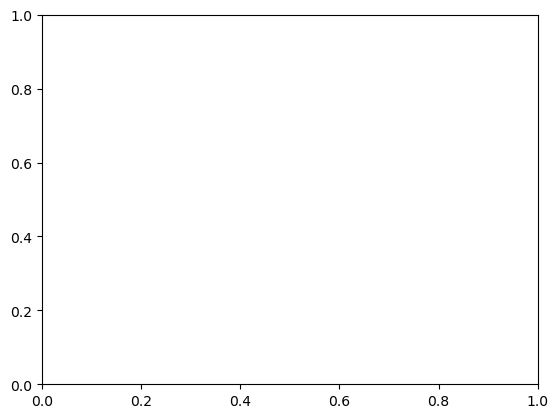

In [95]:
#FIXME: 
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt


def coherence_values_computation(dictionary, corpus, texts, limit, start=2, step=3):
   coherence_values = []
   model_list = []
   for num_topics in range(start, limit, step):
      model = gensim.models.ldamodel.LdaModel(bow, num_topics=num_topics, id2word= doc_dictionary)
      model_list.append(model)
   coherencemodel = CoherenceModel(
      model=model, texts=texts, dictionary=dictionary, coherence='c_v'
   )
   coherence_values.append(coherencemodel.get_coherence())
   return model_list, coherence_values

limit=50; start=1; step=8;

model_list, coherence_values = coherence_values_computation (
   dictionary=doc_dictionary, corpus=bow, texts=clean_text, 
   start=start, limit=limit, step=step
)
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [89]:
import pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow, doc_dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.019051  0.011964       1        1  18.497412
6     -0.033660 -0.029566       2        1  17.900973
0     -0.034999  0.052856       3        1  15.652055
3     -0.120097 -0.066447       4        1  14.035730
1      0.020846  0.130002       5        1  13.017159
4      0.079932 -0.035715       6        1  13.016873
2      0.107029 -0.063092       7        1   7.879798, topic_info=        Term       Freq       Total Category  logprob  loglift
6     system  77.000000   77.000000  Default  30.0000  30.0000
96      page  46.000000   46.000000  Default  29.0000  29.0000
170    error  10.000000   10.000000  Default  28.0000  28.0000
244  consist   8.000000    8.000000  Default  27.0000  27.0000
114   action  17.000000   17.000000  Default  26.0000  26.0000
..       ...        ...         ...      ...      ...      ...
86      user   3.888135  107.809336   Topic7  -3.7951  -0.7816
186  content   2.181930   23.698415   Topic7  -4.3729   0.1557
96      page   2.493575   46.517033   Topic7  -4.2394  -0.3852
85       use   2.073148   47.111722   Topic7  -4.4240  -0.5826
43    applic   1.775338   23.005760   Topic7  -4.5791  -0.0209

[381 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
8         3  0.179860        0
8         4  0.179860        0
8         5  0.359720        0
8         7  0.179860        0
14        4  0.280851        1
...     ...       ...      ...
141       3  0.212929  without
141       4  0.212929  without
141       5  0.425858  without
253       6  0.753103       xx
253       7  0.188276       xx

[713 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 7, 1, 4, 2, 5, 3])

From the above output, the bubbles on the left-side represents a topic and larger the bubble, the more prevalent is that topic. The topic model will be good if the topic model has big, non-overlapping bubbles scattered throughout the chart.

https://www.tutorialspoint.com/gensim/gensim_documents_and_lda_model.htm


## Query, the model using new, unseen documents

In [106]:
other_texts = [
    ['computer', 'time', 'graph'],
    ['survey', 'response', 'eps'],
    ['human', 'system', 'computer']
]
other_corpus = [doc_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[0]
vector = lda_model[unseen_doc]  # get topic probability distribution for a document

pprint.pprint(vector)

# Get the tuple with the highest value based on the second element of each tuple
topic_with_highest_value = max(vector, key=lambda x: x[1])

print("Tuple with the highest value:", topic_with_highest_value)

topic_with_highest_value[1]

lda_model.print_topic(topic_with_highest_value[0])

[(0, 0.07186775),
 (1, 0.07165148),
 (2, 0.071430765),
 (3, 0.071448445),
 (4, 0.07143061),
 (5, 0.07176786),
 (6, 0.5704031)]
Tuple with the highest value: (6, 0.5704031)


'0.056*"user" + 0.043*"page" + 0.029*"system" + 0.028*"link" + 0.022*"text" + 0.018*"within" + 0.017*"applic" + 0.016*"provid" + 0.015*"access" + 0.014*"data"'

## Test Query

In [110]:
# Filter the DataFrame to include only rows where 'tag' is equal to "req"
df_req = df[df['tag'] == 'req'].copy()

# Display the new DataFrame
df_req.head(30)

,tag,text,id,path,text_clean
27,req,The solution should provide detailed context-s...,1,req_document/p/p/req/text_body,"[solut, provid, detail, context, sensit, help,..."
28,req,The solution should provide detailed context-s...,2,req_document/p/p/req/text_body,"[solut, provid, detail, context, sensit, help,..."
30,req,The solution should provide an interface for t...,1,req_document/p/p/req/text_body,"[solut, provid, interfac, user, log, defect, e..."
31,req,"The solution should send alerts (e.g., email, ...",2,req_document/p/p/req/text_body,"[solut, send, alert, e, g, email, sm, user, us..."
32,req,The solution should enable the user to track t...,3,req_document/p/p/req/text_body,"[solut, enabl, user, track, submit, defect, en..."
33,req,The solution should enable the help-desk user ...,4,req_document/p/p/req/text_body,"[solut, enabl, help, desk, user, view, report,..."
34,req,The support solution should be accessible to t...,5,req_document/p/p/req/text_body,"[support, solut, access, user, within, applic,..."
36,req,An audit trail is a record of actions taken by...,1,req_document/p/p/req/text_body,"[audit, trail, record, action, taken, either, ..."
38,req,Once the audit trail functionality has been ac...,2,req_document/p/p/req/text_body,"[audit, trail, function, activ, system, must, ..."
39,req,The System must maintain the audit trail for a...,3,req_document/p/p/req/text_body,"[system, must, maintain, audit, trail, long, r..."


In [115]:
def get_topic_distribution(df, dictionary, lda_model):
    """
    Create a new column 'prob_dist' containing the topic distribution for each document in the DataFrame.

    Parameters:
    - df (pandas.DataFrame): Input DataFrame containing text data.
    - dictionary (gensim.corpora.Dictionary): Gensim dictionary object.
    - lda_model (gensim.models.ldamodel.LdaModel): Trained LDA model.

    Returns:
    - df_with_prob_dist (pandas.DataFrame): DataFrame with an additional column 'prob_dist'.
    """
    # Ensure 'prob_dist' column exists
    df['prob_dist'] = None

    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        # Convert text to bag-of-words representation
        doc_bow = dictionary.doc2bow(row['text_clean'])
        
        # Extract the topic distribution
        topic_distribution = lda_model[doc_bow]

        # Assign the topic distribution to the 'prob_dist' column
        df.at[index, 'prob_dist'] = topic_distribution

    return df


# Usage example:
df_req = get_topic_distribution(df_req, doc_dictionary, lda_model)
df_req.head(30)

,tag,text,id,path,text_clean,prob_dist
27,req,The solution should provide detailed context-s...,1,req_document/p/p/req/text_body,"[solut, provid, detail, context, sensit, help,...","[(0, 0.01302268), (1, 0.92182964), (2, 0.01301..."
28,req,The solution should provide detailed context-s...,2,req_document/p/p/req/text_body,"[solut, provid, detail, context, sensit, help,...","[(0, 0.013022675), (1, 0.92183185), (2, 0.0130..."
30,req,The solution should provide an interface for t...,1,req_document/p/p/req/text_body,"[solut, provid, interfac, user, log, defect, e...","[(0, 0.0143123185), (1, 0.014359198), (2, 0.01..."
31,req,"The solution should send alerts (e.g., email, ...",2,req_document/p/p/req/text_body,"[solut, send, alert, e, g, email, sm, user, us...","[(0, 0.014305982), (1, 0.15576991), (2, 0.0143..."
32,req,The solution should enable the user to track t...,3,req_document/p/p/req/text_body,"[solut, enabl, user, track, submit, defect, en...","[(0, 0.017887091), (1, 0.19746813), (2, 0.7129..."
33,req,The solution should enable the help-desk user ...,4,req_document/p/p/req/text_body,"[solut, enabl, help, desk, user, view, report,...","[(0, 0.010221167), (1, 0.010220933), (2, 0.938..."
34,req,The support solution should be accessible to t...,5,req_document/p/p/req/text_body,"[support, solut, access, user, within, applic,...","[(0, 0.013020107), (1, 0.013019281), (2, 0.013..."
36,req,An audit trail is a record of actions taken by...,1,req_document/p/p/req/text_body,"[audit, trail, record, action, taken, either, ...","[(1, 0.9779771)]"
38,req,Once the audit trail functionality has been ac...,2,req_document/p/p/req/text_body,"[audit, trail, function, activ, system, must, ...","[(0, 0.010218427), (1, 0.93868846), (2, 0.0102..."
39,req,The System must maintain the audit trail for a...,3,req_document/p/p/req/text_body,"[system, must, maintain, audit, trail, long, r...","[(0, 0.21540263), (1, 0.69503325), (2, 0.01792..."
